In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


In [2]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

/Users/abdulmk/opt/anaconda3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.1.1; Torch-cuda version: None; Torch Geometric version: 2.4.0.


In [3]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = './Gift_Cards_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "./meta_Gift_Cards.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [6]:
categories_names = []
for line in file_metadata:
    for cat in line['category']:
        if cat not in categories_names:
            categories_names.append(cat)
        

In [7]:
categories_names

['Gift Cards',
 'Gift Card Accessories',
 '</span></span></span>',
 'No expiration, no fees.',
 'Redeemable toward millions of items storewide on Amazon.com.',
 'Multiple denominations. Choose your amount from $1.00 to $2,000.',
 'Variety of designs for any occasion.',
 'Made with thick, 100% recycled paper stock, sealed with vinyl laminate and hand sewn with clear vinyl pockets',
 "Holds Credit Cards, Business Cards, ID's and or Bus & Train Passes",
 'Great for "going out" or by the pool when just the essentials are needed',
 'Unique, eye-catching designs which rival boring, plain card cases',
 'Handmade with recycled materials in Los Angeles',
 'Starbucks Gift Card 25',
 'Starbucks']

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories_names)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

def vec_to_category(vector) -> str:
    return label_encoder.inverse_transform([np.argmax(vector)])[0]

def categories_to_vec(categories):
    categories = list(set(categories))
    integer_encoded = label_encoder.transform(categories)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    # print(onehot_encoded)
    output = onehot_encoded[0]
    for i in range(1, len(onehot_encoded)):
        output += onehot_encoded[i]
    return output



/Users/abdulmk/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
review_df = pd.DataFrame(review_data,columns=['reviewerID','asin','overall'])
review_df.head()

,reviewerID,asin,overall
0,A31UBHTUUIFJUT,B004LLIKVU,5.0
1,A2MN5JQMIY0FQ2,B004LLIKVU,4.0
2,A25POI5IGGENPM,B004LLIKVU,5.0
3,A2HYGTHB4LJ9FW,B004LLIKVU,5.0
4,ACDG3M94UMZGJ,B004LLIKVU,5.0


In [10]:
from sentence_transformers import SentenceTransformer

class TextEncoder:
    """
    A class for encoding text using a SentenceTransformer model.
    """
    def __init__(self, model='all-MiniLM-L6-v2', device=None):
        """
        :param model: Name of the SentenceTransformer model to use.
        :param device: Device to use for model inference. Default is None.
        """
        self.device = device
        self.model = SentenceTransformer(model, device=self.device)

    @torch.no_grad()
    def __call__(self, values: list):
        """
        Encode a list of text values into embeddings.

        :param values: List of text values to encode.
        :return: Encoded embeddings as a PyTorch tensor.
        """
        x = self.model.encode(values,
                              show_progress_bar=True,
                              convert_to_tensor=True,
                              device=self.device)
        return x.cpu()


# Check if CUDA is available, and set the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Create an instance of the TextEncoder class with the determined device
encoder = TextEncoder(device=device)

In [11]:
metadata_df = pd.DataFrame(file_metadata,columns=['asin','category','title','description','also_buy'])
metadata_df.head()

,asin,category,title,description,also_buy
0,B001BKEWF2,"[Gift Cards, Gift Cards]",Serendipity 3 $100.00 Gift Card,[Gift card for the purchase of goods or servic...,[]
1,B001GXRQW0,"[Gift Cards, Gift Cards]",Amazon.com Gift Cards,[Amazon.com Gift Cards are the perfect way to ...,[]
2,B001H53QE4,"[Gift Cards, Gift Cards]","Amazon.com Gift Cards, Pack of 50 (Old Version...","[<div class=""aplus""> <br>Amazon.com Gift Cards...","[B005ESMEBQ, B007EE5WNA, B007EE5OBU, B07HJHK8Y..."
3,B001H53QEO,"[Gift Cards, Gift Cards]","Amazon.com $50 Gift Cards, Pack of 50 (Old Ve...","[<div class=""aplus""> <h4>Amazon.com Gift Cards...",[]
4,B001KMWN2K,"[Gift Cards, Gift Cards]",Wood Puzzle Magic Box Gift Card,[],[]


In [12]:
del review_data
del file_metadata

In [13]:
unique_user_id = review_df['reviewerID'].unique()
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = metadata_df['asin'].unique()
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

In [14]:
def one_hot(x):
    if len(x) == 0 :
        return np.zeros(shape=(len(onehot_encoded)))
    else:
        return categories_to_vec(x)

In [15]:
metadata_df["category"] = metadata_df["category"].apply(lambda x: one_hot(x))

In [16]:
product_features = torch.zeros(len(unique_product_id), 384 + len(onehot_encoded))
def convert_to_embed(x):
    product = x["asin"]
    mapped_id = unique_product_id.loc[unique_product_id['productId'] == product, 'mappedID'].values[0]
    one_hot =  torch.tensor(x["category"])
    d = ' '.join(x["description"])
    if d == "":
        product_features[mapped_id] = torch.cat((encoder("None"), one_hot), -1)
    else:
        product_features[mapped_id] = torch.cat((encoder(d), one_hot), -1)

In [17]:
metadata_df.apply(lambda x : convert_to_embed(x),axis=1)
print(product_features.shape)

Batches:   0%|                                            | 0/1 [00:00<?, ?it/s]

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.06it/s]

torch.Size([1547, 398])


In [18]:
product_product_edges = []
for product_id in metadata_df["asin"].unique():
   product = metadata_df[metadata_df["asin"] == product_id].iloc[0]
   if len(product["also_buy"]) == 0 :
       continue
   for also_bought_product in product["also_buy"]:
       if (unique_product_id['productId'] == also_bought_product).any():
           product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product_id, 'mappedID'].values[0],
                                     unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
product_product_edges = torch.t(torch.tensor(product_product_edges, dtype=torch.long))
print(product_product_edges.shape)


torch.Size([2, 5993])


In [19]:
user_product_edges = []
user_product_ratings = []
for review in review_df.itertuples():
   user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == review.reviewerID, 'mappedID'].values[0],
                              unique_product_id.loc[unique_product_id['productId'] == review.asin, 'mappedID'].values[0]])
   user_product_ratings.append(review.overall)
user_product_edges = torch.t(torch.tensor(user_product_edges, dtype=torch.long))
user_product_ratings = torch.tensor(user_product_ratings, dtype=torch.float) 
print(user_product_edges.shape)

torch.Size([2, 2972])


In [20]:
from torch_geometric.data import HeteroData
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
# data['User'].x = torch.ones(len(users), 1)
data['User'].x = torch.eye(len(review_df['reviewerID'].unique()))

# Add edge indices to the HeteroData object
data['User', 'REVIEWS', 'Product'].edge_index = user_product_edges
data['User', 'REVIEWS', 'Product'].edge_label = user_product_ratings
data['Product', 'ALSO_BOUGHT', 'Product'].edge_index = product_product_edges

import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['Product', 'rev_REVIEWS', 'User'].edge_label


In [21]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('User', 'REVIEWS', 'Product'), ('Product', 'ALSO_BOUGHT', 'Product')],
    rev_edge_types=[('Product', 'rev_REVIEWS', 'User'),('Product', 'rev_ALSO_BOUGHT', 'Product')],
)(data)
train_data, val_data

# train_data, val_data, test_data = T.RandomLinkSplit(
#     num_val=0.1,
#     num_test=0.1,
#     neg_sampling_ratio=0.0,
#     edge_types=[('User', 'REVIEWS', 'Product')],
#     rev_edge_types=[('Product', 'rev_REVIEWS', 'User')],
# )(data)
train_data, val_data

(HeteroData(
   Product={ x=[1547, 398] },
   User={ x=[458, 458] },
   (User, REVIEWS, Product)={
     edge_index=[2, 2378],
     edge_label=[2378],
     edge_label_index=[2, 2378],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8458],
     edge_label=[8458],
     edge_label_index=[2, 8458],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 2378] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ),
 HeteroData(
   Product={ x=[1547, 398] },
   User={ x=[458, 458] },
   (User, REVIEWS, Product)={
     edge_index=[2, 2378],
     edge_label=[297],
     edge_label_index=[2, 297],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8458],
     edge_label=[1057],
     edge_label_index=[2, 1057],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 2378] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ))

In [22]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [23]:
train_data.edge_index_dict

{('User',
  'REVIEWS',
  'Product'): tensor([[ 295,   35,   36,  ...,  268,  142,    8],
         [ 307,  306, 1179,  ...,  279,  468,  444]]),
 ('Product',
  'ALSO_BOUGHT',
  'Product'): tensor([[ 656,  453, 1179,  ...,  359, 1502,  911],
         [1090,  669, 1175,  ...,  272, 1402,  443]]),
 ('Product',
  'rev_REVIEWS',
  'User'): tensor([[ 307,  306, 1179,  ...,  279,  468,  444],
         [ 295,   35,   36,  ...,  268,  142,    8]])}

In [24]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 100
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 23.2121, Train: 4.3902, Val: 4.3805
Epoch: 002, Loss: 19.2740, Train: 3.4521, Val: 3.4330
Epoch: 003, Loss: 11.9171, Train: 1.6011, Val: 1.5611
Epoch: 004, Loss: 2.5634, Train: 0.5037, Val: 0.5113
Epoch: 005, Loss: 6.9601, Train: 0.5099, Val: 0.5158
Epoch: 006, Loss: 3.9099, Train: 0.6158, Val: 0.6195
Epoch: 007, Loss: 0.5183, Train: 1.2523, Val: 1.2399
Epoch: 008, Loss: 1.5682, Train: 1.7439, Val: 1.7371
Epoch: 009, Loss: 3.0411, Train: 1.7897, Val: 1.7883
Epoch: 010, Loss: 3.2031, Train: 1.4990, Val: 1.5038
Epoch: 011, Loss: 2.2470, Train: 0.9926, Val: 1.0079
Epoch: 012, Loss: 0.9853, Train: 0.5965, Val: 0.6235
Epoch: 013, Loss: 0.5006, Train: 0.5122, Val: 0.5281
Epoch: 014, Loss: 1.2930, Train: 0.5030, Val: 0.5160
Epoch: 015, Loss: 2.0115, Train: 0.5044, Val: 0.5190
Epoch: 016, Loss: 1.4309, Train: 0.5146, Val: 0.5426
Epoch: 017, Loss: 0.5645, Train: 0.6219, Val: 0.6500
Epoch: 018, Loss: 0.3949, Train: 0.8586, Val: 0.8704
Epoch: 019, Loss: 0.7372, Train: 1.0256, Va

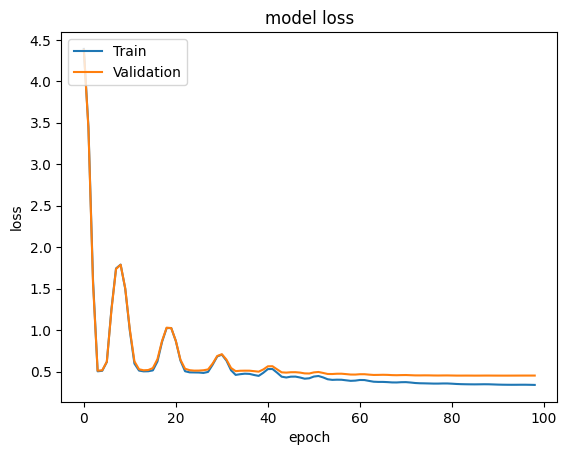

In [25]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [26]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 0.4011
     userId  ProdId    rating  target
0        47     279  5.000000     5.0
1       318    1500  4.865541     5.0
2       353     435  5.000000     5.0
3       405     999  3.071116     5.0
4       129     664  4.969031     5.0
..      ...     ...       ...     ...
292     225     279  5.000000     5.0
293     436    1003  5.000000     5.0
294     305     433  4.880020     5.0
295      77     274  4.542816     5.0
296     231     281  4.985736     5.0

[297 rows x 4 columns]


In [27]:
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [28]:
from torch_geometric.nn import GATConv, GCNConv


In [29]:

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels,heads = 2, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels,heads = 1, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=2)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=2)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=2)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=1)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=1)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=1)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [30]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 100
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 22.8287, Train: 4.5353, Val: 4.5268
Epoch: 002, Loss: 20.5686, Train: 4.0400, Val: 4.0281
Epoch: 003, Loss: 16.3214, Train: 3.0862, Val: 3.0678
Epoch: 004, Loss: 9.5249, Train: 1.3992, Val: 1.3706
Epoch: 005, Loss: 1.9577, Train: 0.5081, Val: 0.5172
Epoch: 006, Loss: 4.6026, Train: 0.5028, Val: 0.5119
Epoch: 007, Loss: 4.8447, Train: 0.5524, Val: 0.5598
Epoch: 008, Loss: 1.2381, Train: 0.7631, Val: 0.7535
Epoch: 009, Loss: 0.5824, Train: 1.2878, Val: 1.2714
Epoch: 010, Loss: 1.6586, Train: 1.5551, Val: 1.5408
Epoch: 011, Loss: 2.4184, Train: 1.5212, Val: 1.5091
Epoch: 012, Loss: 2.3141, Train: 1.2532, Val: 1.2445
Epoch: 013, Loss: 1.5705, Train: 0.8455, Val: 0.8461
Epoch: 014, Loss: 0.7149, Train: 0.5874, Val: 0.6047
Epoch: 015, Loss: 0.3660, Train: 0.5198, Val: 0.5375
Epoch: 016, Loss: 0.7973, Train: 0.5002, Val: 0.5159
Epoch: 017, Loss: 1.3682, Train: 0.5010, Val: 0.5172
Epoch: 018, Loss: 1.2398, Train: 0.5179, Val: 0.5373
Epoch: 019, Loss: 0.6682, Train: 0.5592, Va

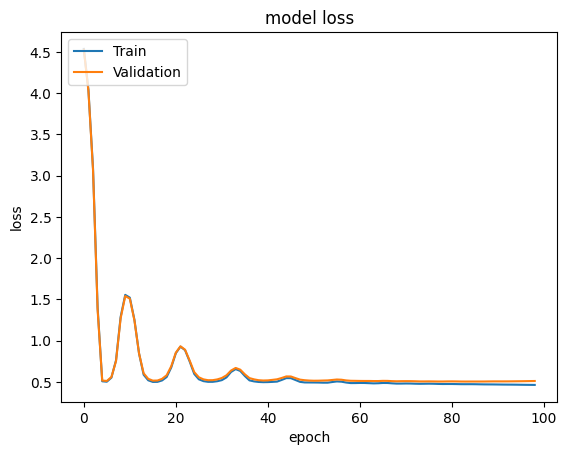

In [31]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [32]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 0.4744
     userId  ProdId    rating  target
0        47     279  4.956872     5.0
1       318    1500  4.938939     5.0
2       353     435  4.834469     5.0
3       405     999  4.096760     5.0
4       129     664  4.985113     5.0
..      ...     ...       ...     ...
292     225     279  4.906374     5.0
293     436    1003  5.000000     5.0
294     305     433  4.837745     5.0
295      77     274  4.886575     5.0
296     231     281  5.000000     5.0

[297 rows x 4 columns]


In [163]:
max_reviews_reviewer = review_df.groupby('reviewerID').size().idxmax()


In [164]:
max_reviews_reviewer

'A1U1G73EI5IRZF'

In [165]:
mapped_user_id = unique_user_id.loc[unique_user_id['userId'] == 'A1U1G73EI5IRZF', 'mappedID'].values[0]
print(mapped_user_id)
products_rated = review_df[review_df['reviewerID'] == 'A2MN5JQMIY0FQ2']
products_not_rated = metadata_df[~metadata_df.asin.isin(products_rated['asin'])]
products_not_rated = products_not_rated.merge(unique_product_id, left_on='asin', right_on='productId', how='inner')
product = products_not_rated.sample(1)

77


In [166]:
product_id_mapped = product["mappedID"].item()

In [167]:
edge_label_index = torch.tensor([
    mapped_user_id,
    product_id_mapped])


with torch.no_grad():
    test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict, edge_label_index)
    pred = pred.clamp(min=0, max=5).detach().cpu().numpy()
print(pred.item())

2.7945125102996826


In [168]:
from torch_geometric.explain import Explainer, CaptumExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type=None,
    edge_mask_type='object',
)

explanation = explainer(
    test_data.x_dict, test_data.edge_index_dict, index=0,
    edge_label_index=edge_label_index).cpu().detach()
explanation

HeteroExplanation(
  prediction=[1],
  target=[1],
  index=[1],
  edge_label_index=[2],
  Product={ x=[1547, 398] },
  User={ x=[458, 458] },
  (User, REVIEWS, Product)={
    edge_mask=[2675],
    edge_index=[2, 2675],
  },
  (Product, ALSO_BOUGHT, Product)={
    edge_mask=[9515],
    edge_index=[2, 9515],
  },
  (Product, rev_REVIEWS, User)={
    edge_mask=[2675],
    edge_index=[2, 2675],
  }
)

In [169]:
prod_id = unique_product_id.loc[unique_product_id['mappedID'] == product_id_mapped, 'productId'].values[0]
title = metadata_df.loc[metadata_df["asin"] == prod_id,"title"].values[0]
user_to_product = explanation['User', 'Product'].edge_index.numpy().T
user_to_product_attr = explanation['User', 'Product'].edge_mask.numpy().T
user_to_product_df = pd.DataFrame(
    np.hstack([user_to_product, user_to_product_attr.reshape(-1,1)]),
    columns = ['mappedUserId', 'mappedProductId', 'attr']
)

product_to_user = explanation['Product', 'User'].edge_index.numpy().T
product_to_user_attr = explanation[ 'Product', 'User'].edge_mask.numpy().T
product_to_user_df = pd.DataFrame(
    np.hstack([product_to_user, product_to_user_attr.reshape(-1,1)]),
    columns = ['mappedProductId', 'mappedUserId','attr']
)
explanation_df = pd.concat([user_to_product_df, product_to_user_df])
explanation_df[["mappedUserId", "mappedProductId"]] = explanation_df[["mappedUserId", "mappedProductId"]].astype(int)

print(f"Attribtion for all edges towards prediction of Product rating of Product:\n {title}")
print("==========================================================================================")
print(explanation_df.sort_values(by='attr'))

Attribtion for all edges towards prediction of Product rating of Product:
 Einstein Bros/ Noah Bagels Gift Card
      mappedUserId  mappedProductId         attr
396            426             1175 -0.001721017
1422           405              472 -0.001364880
2045           349              358 -0.000346813
564            270              298 -0.000102277
2012           270              309 -0.000049408
...            ...              ...          ...
1146            77             1231  0.013472095
1381            77              281  0.013626249
435             77             1509  0.013837969
2392            77              446  0.014123730
349             77             1003  0.014271670

[5350 rows x 3 columns]


In [170]:
explanation_df = explanation_df[explanation_df['mappedUserId'] == mapped_user_id]
explanation_df = explanation_df.groupby('mappedProductId').sum()
explanation_df = explanation_df.merge(unique_product_id, left_on='mappedProductId', right_on='mappedID', how='inner')
explanation_df = explanation_df.merge(metadata_df, left_on='productId', right_on='asin', how='inner')
pd.options.display.float_format = "{:,.9f}".format

print("Top products that influenced the prediction:")
print("==============================================")
print(explanation_df.sort_values(by='attr', ascending=False, key= lambda x: abs(x))[['title', 'attr']].head())

Top products that influenced the prediction:
                                                title        attr
10                                   SUBWAY Gift Card 0.017502206
16   Texas Roadhouse Ribbon Gift Cards Configurati... 0.014558560
7                                  Fandango Gift Card 0.014258392
24                 Amazon.com Gift Card in a Gift Tag 0.013897922
2                                      IHOP Gift Card 0.013657600
